<a href="https://colab.research.google.com/github/LeeDongGeon1996/TensorFlow-study-note/blob/master/my-practice/Experiment_07_Generate_MNIST_dataset_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment_07_Generate_MNIST_dataset_using_GAN



In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

learning_rate = 0.0005
training_epochs = 1
batch_size = 100

mnist = keras.datasets.mnist

TensorFlow 2.x selected.
2.1.0
2.2.4-tf


In [0]:
class GAN(keras.models.Sequential):
  def __init__(self):
    super().__init__()

    #self.generator = self.create_generator()
    self.generator = self.get_generator()
    self.discriminator = self.create_discriminator()

    self.compile_all()

  def compile_all(self):
    opt_G = keras.optimizers.SGD(learning_rate=0.002, momentum=0.9, nesterov=True)
    opt_D = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    #compile entire network
    self.add(self.generator)
    self.discriminator.trainable = False
    self.add(self.discriminator)

    self.compile(loss='binary_crossentropy', optimizer=opt_G)

    #compile disc network
    self.discriminator.trainable = True
    self.discriminator.compile(loss='binary_crossentropy', optimizer=opt_D)
    
  def create_generator(self):
    activation_func = 'tanh'
 
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=256, activation=activation_func, input_dim=784))
    model.add(keras.layers.Dense(units=512, activation=activation_func))
    model.add(keras.layers.Dense(units=1024, activation=activation_func))
    #avoid overfitting
    model.add(layers.BatchNormalization())
    model.add(keras.layers.Dense(units=784, activation=tf.nn.sigmoid))
    model.add(keras.layers.Reshape((28,28,1)))
    #model.add(keras.layers.Activation(self.change_dims))
    return model

  def normalization(self,x):
    return (x+1.)/2

  def get_generator(self):
    generator = keras.models.Sequential()
    generator.add(keras.layers.Dense(256, input_dim=784))
    generator.add(keras.layers.LeakyReLU(0.2))

    generator.add(keras.layers.Dense(512))
    generator.add(keras.layers.LeakyReLU(0.2))

    generator.add(keras.layers.Dense(1024))
    generator.add(keras.layers.LeakyReLU(0.2))

    generator.add(keras.layers.Dense(784, activation='tanh'))
    generator.add(keras.layers.Activation(self.normalization))
    generator.add(keras.layers.Reshape((28,28,1)))
    return generator

  def create_discriminator(self):
    model = keras.models.Sequential()
    #model.add(keras.layers.Activation(self.expand_dim))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

  def _create_noise(self, length):
    return tf.random.uniform((length, 784), -1., 1.)


  def _get_mnist(self, batch_size):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    train_images = train_images.astype('float32') / 255.
    test_images = test_images.astype('float32') / 255.

    return train_images, test_images

  def _train_once(self, x):
    length = x.shape[0]
    
    noise_images = self._create_noise(length)
    
    fake_images = self.generator.predict(noise_images, verbose=0)
    
    y_data = [1]*length + [0]*length
    y_data = tf.convert_to_tensor(y_data)
    
    fake_images = tf.reshape(fake_images, (length, 28, 28))
    x_data = tf.concat([x, fake_images],0)
    x_data = tf.reshape(x_data, (x_data.shape[0], 28, 28, 1))

    #x_data = tf.reshape(x, (x.shape[0], 28, 28, 1))
    #x_data = tf.concat([x_data, fake_images],0)
    #print('concat : ' + str(x_data.shape))
    loss_D = self.discriminator.train_on_batch(x_data, y_data)

    self.discriminator.trainable = False
    #discriminator true로 인식하도록 해야한다.
    length_twice = length
    y_data = [1]*length_twice
    y_data = tf.convert_to_tensor(y_data)
    x_data = self._create_noise(length_twice)
    loss_G = self.train_on_batch(x_data, y_data)
    self.discriminator.trainable = True

    return loss_G, loss_D

  def get_x(self, x_train, index, batch_size):
    return x_train[index * batch_size:(index + 1) * batch_size]

  def _show_image(self, image):

    plt.figure(figsize=(10, 5))
    for i in range(int(image.shape[0])):

      plt.subplot(2,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(image[i], cmap='gray_r')
    plt.show()


  def train(self):
    epochs = 500
    batch_size = 600

    train_images, test_images = self._get_mnist(600)

    for epoch in range(epochs):
      for index in range(int(train_images.shape[0] / batch_size)):
        loss_G, loss_D = self._train_once(self.get_x(train_images, index, batch_size))

      if (epoch%1 == 0) or (epoch == epochs-1):
        print('epoch[' + str(epoch) + '] loss_G : ' + str(loss_G) + ', loss_D : ' + str(loss_D)) 
        create_num = 10
        created_image = self.generator.predict(self._create_noise(create_num))
        created_image = tf.reshape(created_image, (create_num, 28, 28))
        created_image = created_image*255
      if (epoch%5 == 0) or (epoch == epochs-1):
          self._show_image(created_image)

    

epoch[0] loss_G : 0.9240024, loss_D : 0.578034


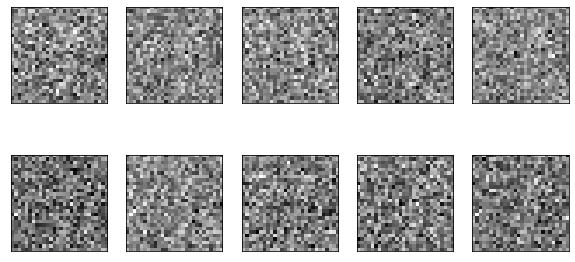

epoch[1] loss_G : 1.540738, loss_D : 0.30687526
epoch[2] loss_G : 0.9204997, loss_D : 0.6754257
epoch[3] loss_G : 0.96115226, loss_D : 0.54308647
epoch[4] loss_G : 1.2682357, loss_D : 0.3761295
epoch[5] loss_G : 1.2511071, loss_D : 0.40486467


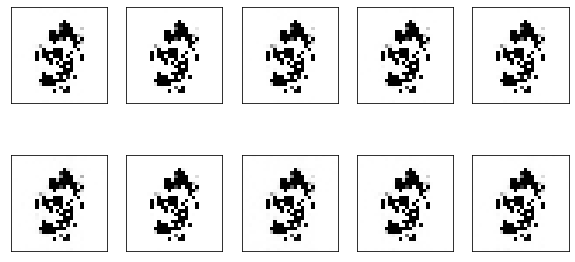

epoch[6] loss_G : 1.6696583, loss_D : 0.27845535
epoch[7] loss_G : 2.1794775, loss_D : 0.16751532
epoch[8] loss_G : 2.2390006, loss_D : 0.16359793
epoch[9] loss_G : 2.6659458, loss_D : 0.09736188
epoch[10] loss_G : 2.6387296, loss_D : 0.09389782


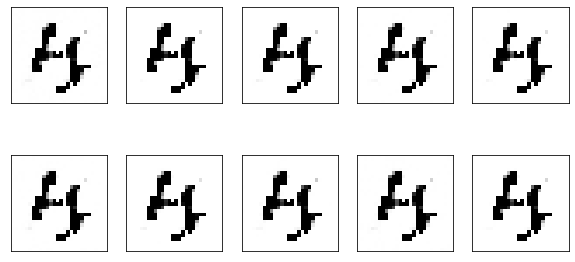

epoch[11] loss_G : 2.7447178, loss_D : 0.08069517
epoch[12] loss_G : 3.0619633, loss_D : 0.061481863
epoch[13] loss_G : 3.0853653, loss_D : 0.06166605
epoch[14] loss_G : 3.5809016, loss_D : 0.043905042
epoch[15] loss_G : 3.3882966, loss_D : 0.06287625


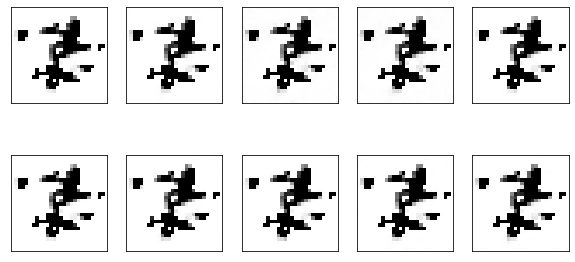

epoch[16] loss_G : 3.7488115, loss_D : 0.04017365
epoch[17] loss_G : 4.034902, loss_D : 0.028264796
epoch[18] loss_G : 4.0710754, loss_D : 0.02824787
epoch[19] loss_G : 4.2357793, loss_D : 0.023884013
epoch[20] loss_G : 4.6316495, loss_D : 0.015200327


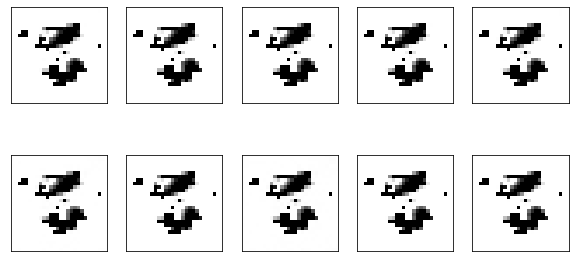

epoch[21] loss_G : 4.747916, loss_D : 0.0148065565
epoch[22] loss_G : 4.7464614, loss_D : 0.012655737
epoch[23] loss_G : 4.761504, loss_D : 0.013876769
epoch[24] loss_G : 4.0806255, loss_D : 0.02506354
epoch[25] loss_G : 4.205372, loss_D : 0.02225172


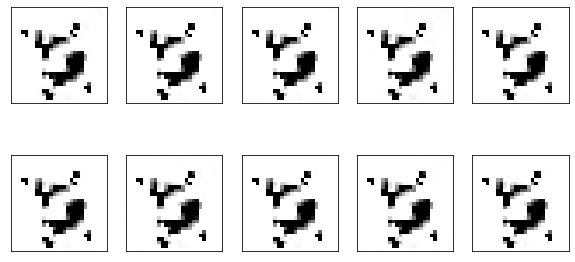

epoch[26] loss_G : 3.9621696, loss_D : 0.024634494
epoch[27] loss_G : 4.0741434, loss_D : 0.024814311
epoch[28] loss_G : 4.1468782, loss_D : 0.023349669
epoch[29] loss_G : 4.4604545, loss_D : 0.017583195
epoch[30] loss_G : 3.8245711, loss_D : 0.033034604


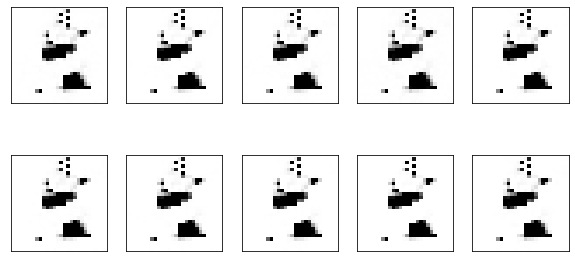

epoch[31] loss_G : 4.258835, loss_D : 0.024212023
epoch[32] loss_G : 2.9825933, loss_D : 0.075276375
epoch[33] loss_G : 3.2342248, loss_D : 0.058799084
epoch[34] loss_G : 3.506962, loss_D : 0.04781681
epoch[35] loss_G : 3.9766524, loss_D : 0.027062152


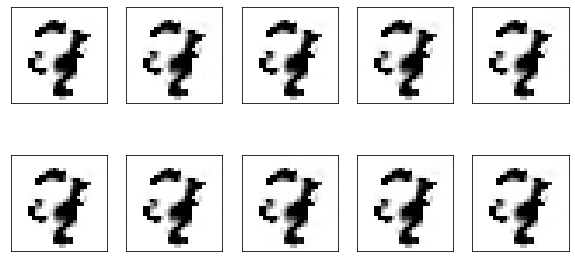

epoch[36] loss_G : 3.8365512, loss_D : 0.035861894
epoch[37] loss_G : 3.3927548, loss_D : 0.049906526
epoch[38] loss_G : 3.0981612, loss_D : 0.05830662
epoch[39] loss_G : 3.0952034, loss_D : 0.056735884
epoch[40] loss_G : 2.394734, loss_D : 0.14150192


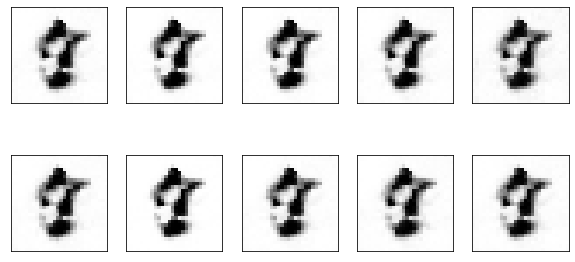

epoch[41] loss_G : 2.5566118, loss_D : 0.098979324
epoch[42] loss_G : 3.0607471, loss_D : 0.062108923
epoch[43] loss_G : 2.879039, loss_D : 0.078816436
epoch[44] loss_G : 3.1218324, loss_D : 0.07723141
epoch[45] loss_G : 3.0780566, loss_D : 0.07318278


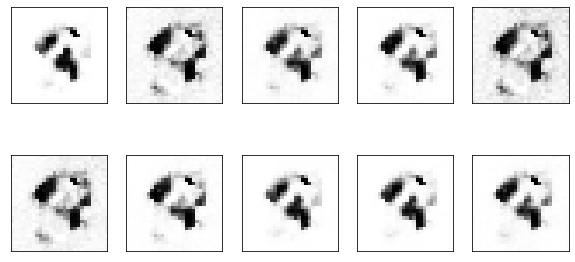

epoch[46] loss_G : 3.230228, loss_D : 0.06296833
epoch[47] loss_G : 3.0846791, loss_D : 0.07111203
epoch[48] loss_G : 2.667226, loss_D : 0.12756117
epoch[49] loss_G : 2.7893968, loss_D : 0.093978375
epoch[50] loss_G : 3.176882, loss_D : 0.06350675


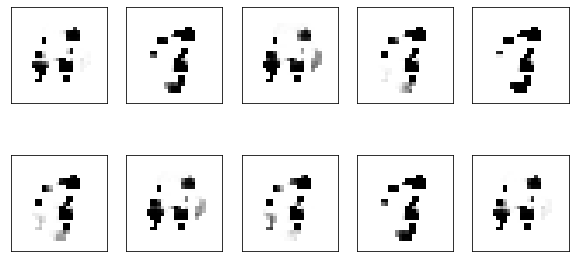

epoch[51] loss_G : 3.7516923, loss_D : 0.04445111
epoch[52] loss_G : 3.6698453, loss_D : 0.04204998
epoch[53] loss_G : 3.4049149, loss_D : 0.06384674
epoch[54] loss_G : 3.9832368, loss_D : 0.042399157
epoch[55] loss_G : 4.060774, loss_D : 0.03623547


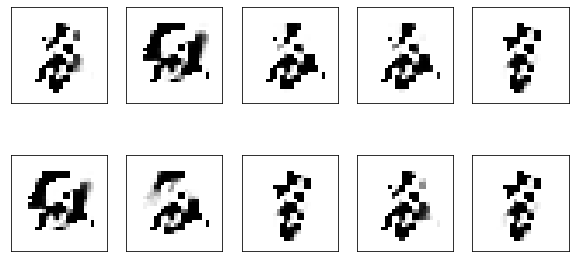

epoch[56] loss_G : 4.0815167, loss_D : 0.043781146
epoch[57] loss_G : 3.9598837, loss_D : 0.042280097
epoch[58] loss_G : 4.1251197, loss_D : 0.037361547
epoch[59] loss_G : 4.890758, loss_D : 0.013574638
epoch[60] loss_G : 5.040237, loss_D : 0.015175101


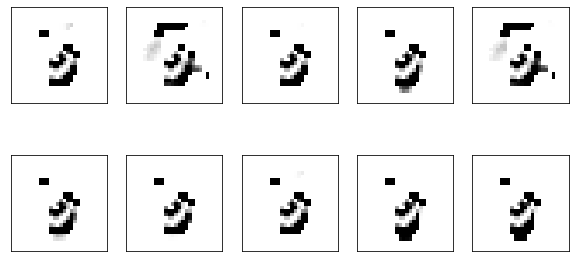

epoch[61] loss_G : 5.1082134, loss_D : 0.011645603
epoch[62] loss_G : 5.4439216, loss_D : 0.006451167
epoch[63] loss_G : 5.7341914, loss_D : 0.011262853
epoch[64] loss_G : 4.8455114, loss_D : 0.016604027
epoch[65] loss_G : 5.2517247, loss_D : 0.008494945


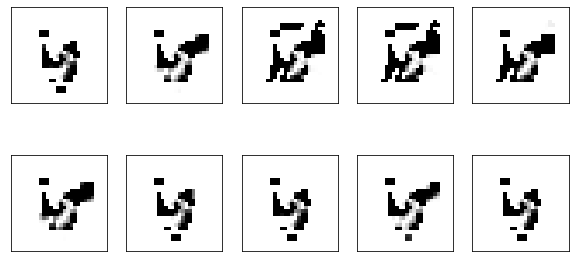

epoch[66] loss_G : 5.6854687, loss_D : 0.0052207247
epoch[67] loss_G : 5.940364, loss_D : 0.0044087935
epoch[68] loss_G : 6.3080006, loss_D : 0.00422427
epoch[69] loss_G : 6.161867, loss_D : 0.0049446295
epoch[70] loss_G : 6.5180736, loss_D : 0.0028065224


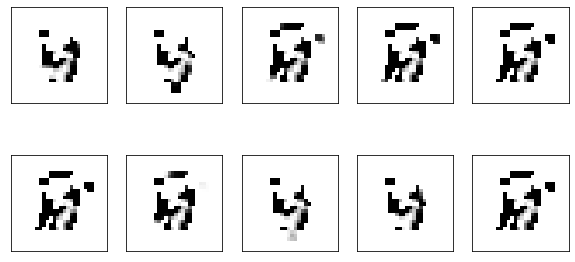

epoch[71] loss_G : 6.341683, loss_D : 0.0037383866
epoch[72] loss_G : 6.298388, loss_D : 0.0037725226
epoch[73] loss_G : 6.0749955, loss_D : 0.0042187693
epoch[74] loss_G : 5.0605364, loss_D : 0.01927937
epoch[75] loss_G : 5.608219, loss_D : 0.010357537


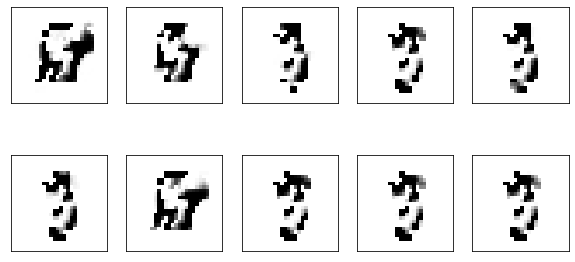

epoch[76] loss_G : 5.6521344, loss_D : 0.013097921
epoch[77] loss_G : 5.268528, loss_D : 0.010555306
epoch[78] loss_G : 4.9071717, loss_D : 0.017363269
epoch[79] loss_G : 4.9070234, loss_D : 0.012970429
epoch[80] loss_G : 5.2778683, loss_D : 0.008052963


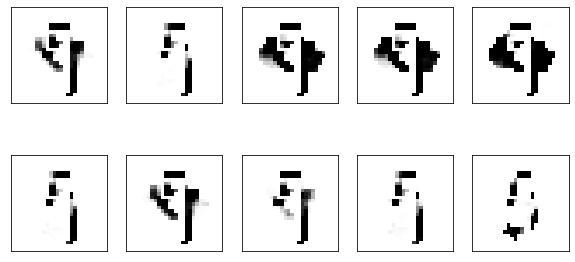

epoch[81] loss_G : 5.775481, loss_D : 0.0078082476
epoch[82] loss_G : 5.2133546, loss_D : 0.020053236
epoch[83] loss_G : 4.9500194, loss_D : 0.024615575
epoch[84] loss_G : 5.1149006, loss_D : 0.024030723
epoch[85] loss_G : 4.976207, loss_D : 0.022426613


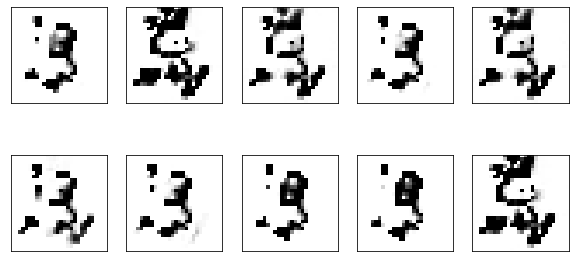

epoch[86] loss_G : 4.229903, loss_D : 0.033890467
epoch[87] loss_G : 4.375807, loss_D : 0.038398966
epoch[88] loss_G : 4.89249, loss_D : 0.030777063
epoch[89] loss_G : 3.9945362, loss_D : 0.05032511
epoch[90] loss_G : 3.7070243, loss_D : 0.055736598


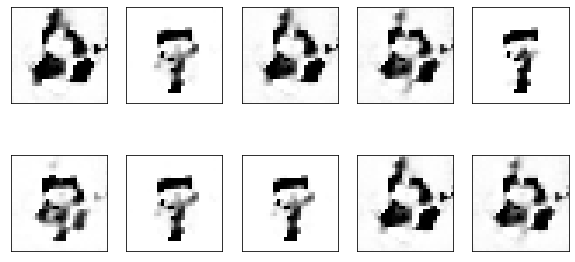

epoch[91] loss_G : 2.8502216, loss_D : 0.117923595
epoch[92] loss_G : 2.998829, loss_D : 0.09303157
epoch[93] loss_G : 2.875964, loss_D : 0.089106776
epoch[94] loss_G : 2.7668076, loss_D : 0.11052414
epoch[95] loss_G : 3.1528091, loss_D : 0.08401848


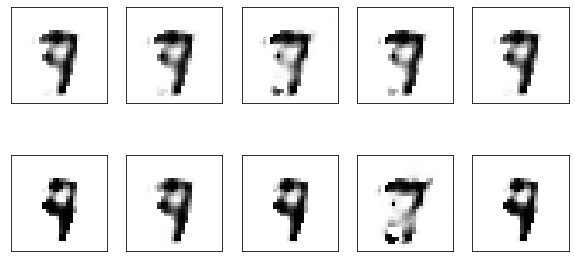

epoch[96] loss_G : 3.4007456, loss_D : 0.071157694
epoch[97] loss_G : 2.938412, loss_D : 0.090598844
epoch[98] loss_G : 3.2931268, loss_D : 0.08974236
epoch[99] loss_G : 3.425536, loss_D : 0.06335988
epoch[100] loss_G : 3.7829764, loss_D : 0.050499707


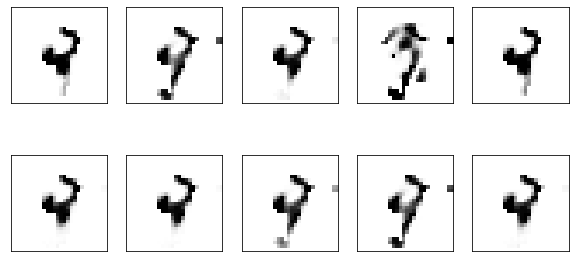

epoch[101] loss_G : 4.480037, loss_D : 0.040237255
epoch[102] loss_G : 3.950641, loss_D : 0.05105353
epoch[103] loss_G : 4.304878, loss_D : 0.05049746
epoch[104] loss_G : 4.068222, loss_D : 0.03870193
epoch[105] loss_G : 4.09215, loss_D : 0.036157895


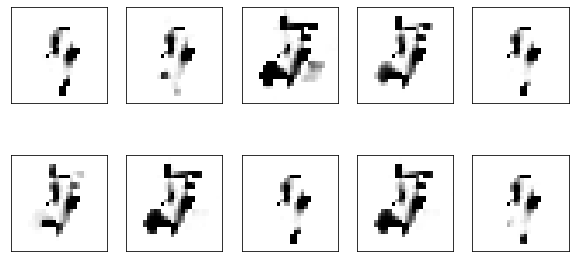

epoch[106] loss_G : 3.8726606, loss_D : 0.0685813
epoch[107] loss_G : 3.8832536, loss_D : 0.05470031
epoch[108] loss_G : 3.8334627, loss_D : 0.054605585
epoch[109] loss_G : 4.506367, loss_D : 0.028551249
epoch[110] loss_G : 4.5727916, loss_D : 0.031093212


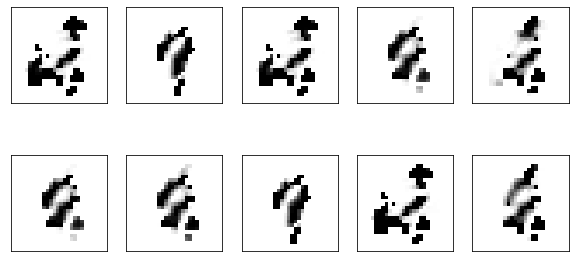

epoch[111] loss_G : 4.796774, loss_D : 0.028303111
epoch[112] loss_G : 5.0544186, loss_D : 0.015834901
epoch[113] loss_G : 5.2228184, loss_D : 0.013921895
epoch[114] loss_G : 4.931395, loss_D : 0.016581522
epoch[115] loss_G : 4.4864473, loss_D : 0.030576669


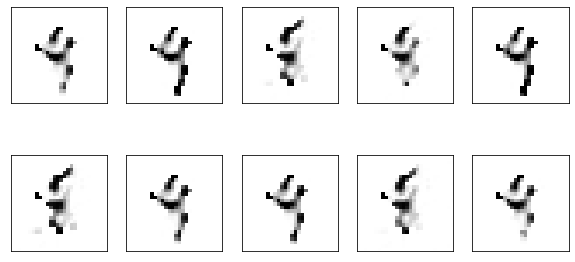

epoch[116] loss_G : 4.4394755, loss_D : 0.026394667
epoch[117] loss_G : 3.936151, loss_D : 0.077900305
epoch[118] loss_G : 3.689301, loss_D : 0.10043976
epoch[119] loss_G : 3.1202884, loss_D : 0.109537125
epoch[120] loss_G : 3.003978, loss_D : 0.096720785


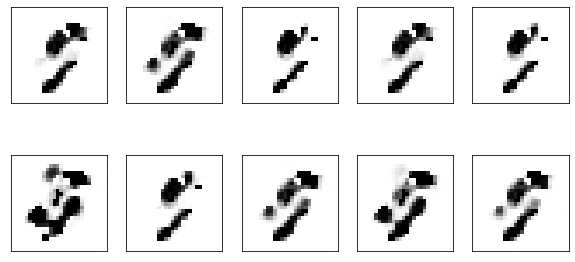

epoch[121] loss_G : 2.9911757, loss_D : 0.09445365
epoch[122] loss_G : 3.4216175, loss_D : 0.070386715
epoch[123] loss_G : 3.4728882, loss_D : 0.062407024
epoch[124] loss_G : 3.9053674, loss_D : 0.05638792
epoch[125] loss_G : 3.248257, loss_D : 0.09104943


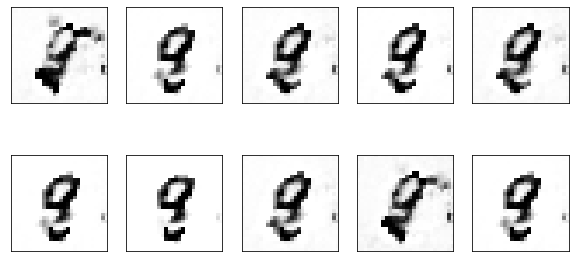

epoch[126] loss_G : 2.9026053, loss_D : 0.08191938
epoch[127] loss_G : 3.3113594, loss_D : 0.053213477
epoch[128] loss_G : 3.3487604, loss_D : 0.0990012
epoch[129] loss_G : 3.5099902, loss_D : 0.06817772
epoch[130] loss_G : 3.2220774, loss_D : 0.10268104


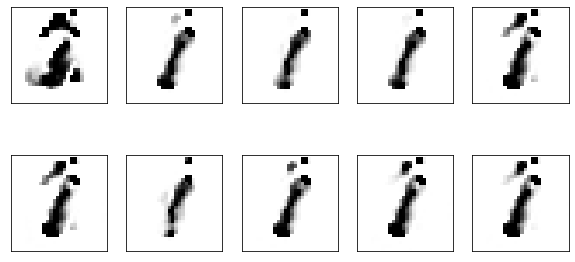

epoch[131] loss_G : 3.1345804, loss_D : 0.08509297
epoch[132] loss_G : 3.1571717, loss_D : 0.07921786
epoch[133] loss_G : 3.2972832, loss_D : 0.08032492
epoch[134] loss_G : 3.5761845, loss_D : 0.06648425
epoch[135] loss_G : 2.9983287, loss_D : 0.08683114


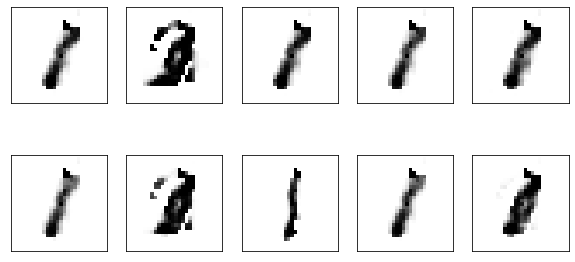

epoch[136] loss_G : 3.443158, loss_D : 0.06689844
epoch[137] loss_G : 3.2480357, loss_D : 0.08208999
epoch[138] loss_G : 3.2857943, loss_D : 0.071700886
epoch[139] loss_G : 3.4801865, loss_D : 0.06891965
epoch[140] loss_G : 3.3022213, loss_D : 0.06990272


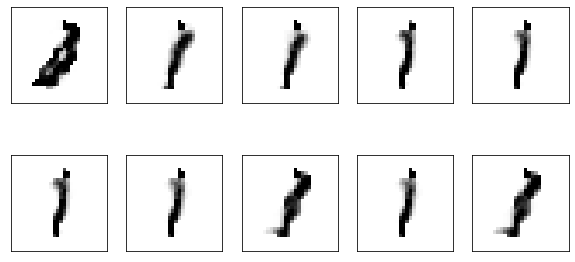

epoch[141] loss_G : 3.7442298, loss_D : 0.054964207
epoch[142] loss_G : 3.4361122, loss_D : 0.07527947
epoch[143] loss_G : 3.115204, loss_D : 0.08204061
epoch[144] loss_G : 3.2657018, loss_D : 0.056687236
epoch[145] loss_G : 3.763503, loss_D : 0.050259516


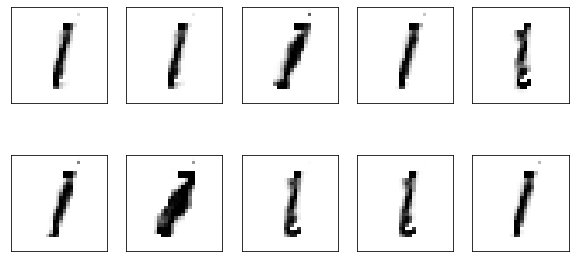

epoch[146] loss_G : 3.7384596, loss_D : 0.045413308
epoch[147] loss_G : 4.008994, loss_D : 0.051340487
epoch[148] loss_G : 3.4232275, loss_D : 0.079360716
epoch[149] loss_G : 3.563612, loss_D : 0.06880492
epoch[150] loss_G : 3.4744124, loss_D : 0.069161594


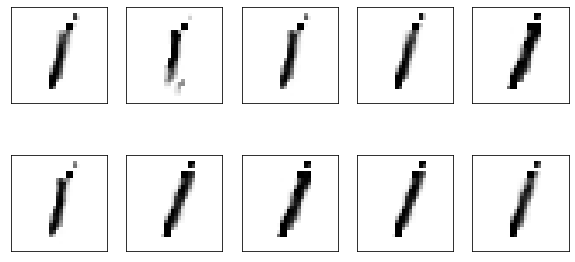

epoch[151] loss_G : 3.6390734, loss_D : 0.052831132
epoch[152] loss_G : 3.487163, loss_D : 0.06115236
epoch[153] loss_G : 3.5744405, loss_D : 0.05959483
epoch[154] loss_G : 3.3957293, loss_D : 0.07280611
epoch[155] loss_G : 3.5457718, loss_D : 0.065477036


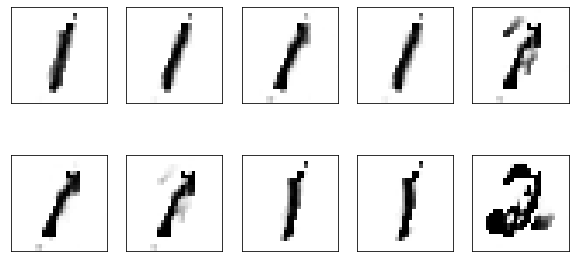

epoch[156] loss_G : 3.420687, loss_D : 0.089384735
epoch[157] loss_G : 3.6240327, loss_D : 0.0634395
epoch[158] loss_G : 3.2136462, loss_D : 0.09260834
epoch[159] loss_G : 3.4064922, loss_D : 0.07042248
epoch[160] loss_G : 3.7194707, loss_D : 0.076396376


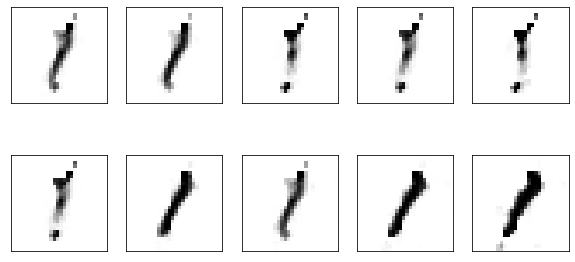

epoch[161] loss_G : 3.6708114, loss_D : 0.06517453
epoch[162] loss_G : 3.304885, loss_D : 0.062476147
epoch[163] loss_G : 3.274373, loss_D : 0.08199254
epoch[164] loss_G : 3.5315156, loss_D : 0.056123555
epoch[165] loss_G : 3.5447958, loss_D : 0.07561518


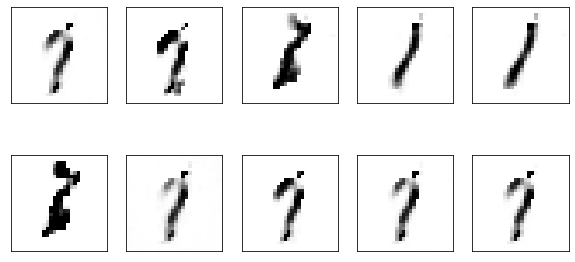

epoch[166] loss_G : 3.4341867, loss_D : 0.06322087
epoch[167] loss_G : 3.378012, loss_D : 0.079954214
epoch[168] loss_G : 3.1361697, loss_D : 0.10302173
epoch[169] loss_G : 3.6446264, loss_D : 0.06375041
epoch[170] loss_G : 3.4576175, loss_D : 0.08992176


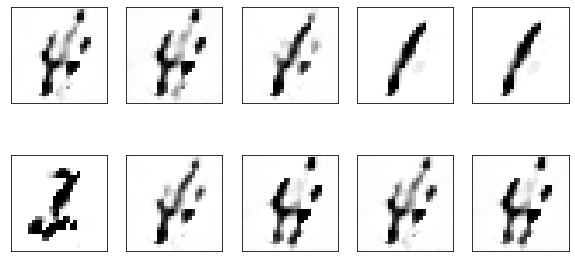

epoch[171] loss_G : 3.8651962, loss_D : 0.070420735
epoch[172] loss_G : 3.7932913, loss_D : 0.06488287
epoch[173] loss_G : 3.571392, loss_D : 0.066792145
epoch[174] loss_G : 3.774121, loss_D : 0.062092178
epoch[175] loss_G : 3.3569298, loss_D : 0.06555898


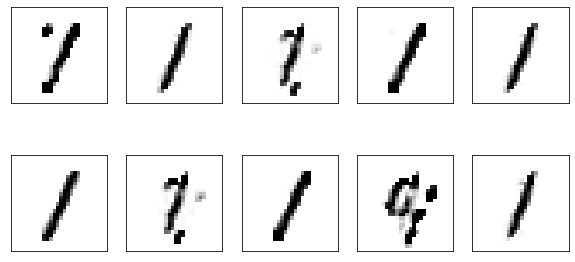

epoch[176] loss_G : 3.6995776, loss_D : 0.06126754
epoch[177] loss_G : 3.9280102, loss_D : 0.05365771
epoch[178] loss_G : 4.1916537, loss_D : 0.04164813
epoch[179] loss_G : 3.9693599, loss_D : 0.052122988
epoch[180] loss_G : 3.9445634, loss_D : 0.046470854


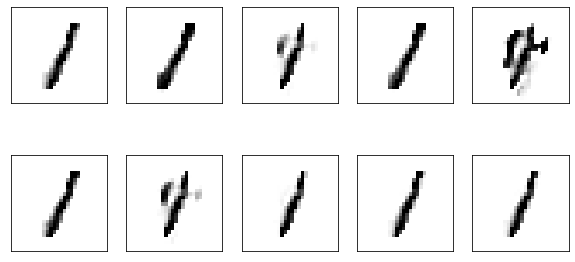

epoch[181] loss_G : 4.0600934, loss_D : 0.060750816
epoch[182] loss_G : 3.961307, loss_D : 0.053547762
epoch[183] loss_G : 4.281645, loss_D : 0.050927866
epoch[184] loss_G : 4.2233005, loss_D : 0.04730477
epoch[185] loss_G : 4.240019, loss_D : 0.043766163


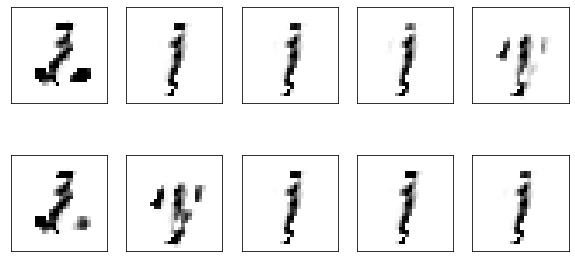

epoch[186] loss_G : 4.408697, loss_D : 0.02158877
epoch[187] loss_G : 4.7729464, loss_D : 0.020870129
epoch[188] loss_G : 4.8295107, loss_D : 0.020041818
epoch[189] loss_G : 5.4148574, loss_D : 0.014758216
epoch[190] loss_G : 4.772234, loss_D : 0.028583733


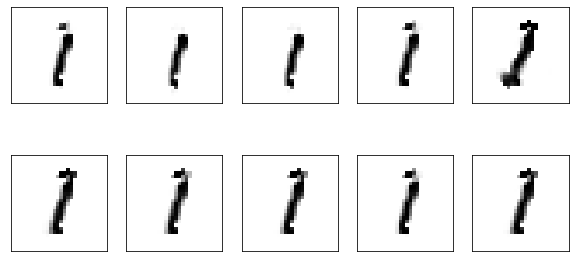

epoch[191] loss_G : 4.9301357, loss_D : 0.027107028
epoch[192] loss_G : 4.524732, loss_D : 0.028694306
epoch[193] loss_G : 3.9598153, loss_D : 0.042833716
epoch[194] loss_G : 3.9097786, loss_D : 0.049782455
epoch[195] loss_G : 4.1120133, loss_D : 0.03837708


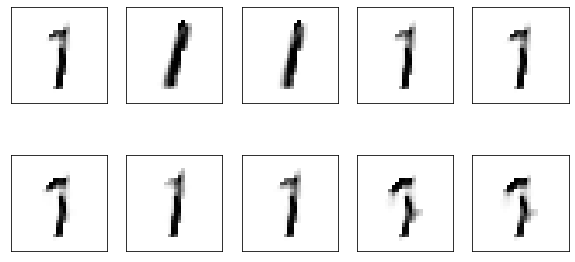

epoch[196] loss_G : 3.7641194, loss_D : 0.050247744
epoch[197] loss_G : 4.5965176, loss_D : 0.043036077
epoch[198] loss_G : 3.7737963, loss_D : 0.050784193
epoch[199] loss_G : 3.5278308, loss_D : 0.059900034
epoch[200] loss_G : 3.351802, loss_D : 0.083196595


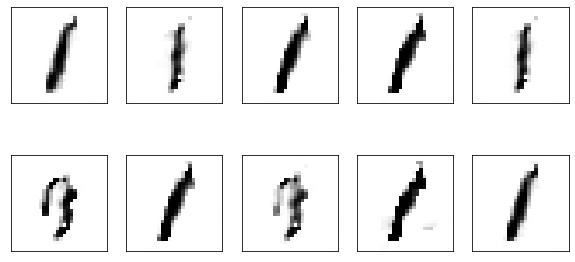

epoch[201] loss_G : 3.3602922, loss_D : 0.07025958
epoch[202] loss_G : 3.3526065, loss_D : 0.076824605
epoch[203] loss_G : 3.371183, loss_D : 0.07159578
epoch[204] loss_G : 3.9696937, loss_D : 0.045311946
epoch[205] loss_G : 3.5965738, loss_D : 0.059040602


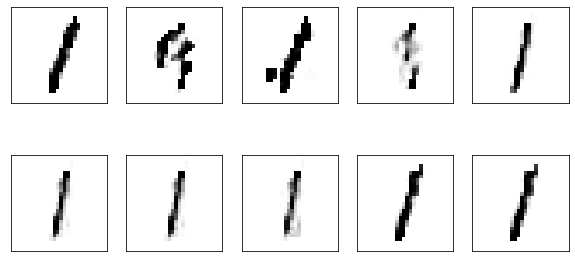

epoch[206] loss_G : 4.032385, loss_D : 0.057139568
epoch[207] loss_G : 3.724336, loss_D : 0.05536785
epoch[208] loss_G : 3.867974, loss_D : 0.05149346
epoch[209] loss_G : 3.9791496, loss_D : 0.05388275
epoch[210] loss_G : 4.0060844, loss_D : 0.03803147


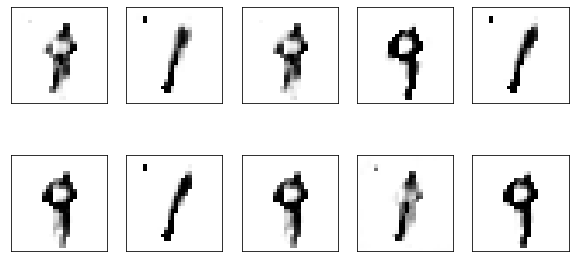

epoch[211] loss_G : 3.647344, loss_D : 0.052468088
epoch[212] loss_G : 3.567017, loss_D : 0.054855887
epoch[213] loss_G : 3.3480814, loss_D : 0.087109745
epoch[214] loss_G : 2.9658344, loss_D : 0.09701872
epoch[215] loss_G : 3.3463826, loss_D : 0.101703286


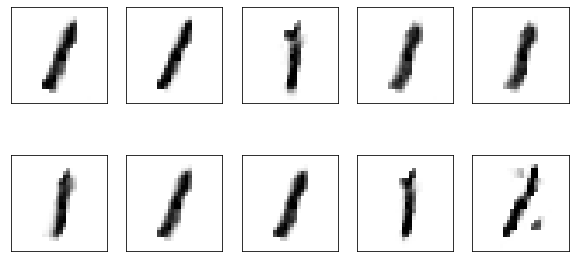

epoch[216] loss_G : 3.2597892, loss_D : 0.07793677
epoch[217] loss_G : 3.1443279, loss_D : 0.09600325
epoch[218] loss_G : 3.5637603, loss_D : 0.06942477
epoch[219] loss_G : 3.2872717, loss_D : 0.09778155
epoch[220] loss_G : 3.467789, loss_D : 0.08447536


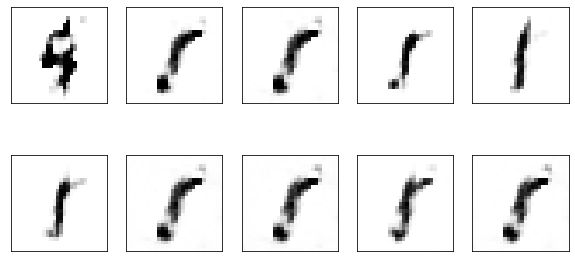

epoch[221] loss_G : 3.7037117, loss_D : 0.07361599
epoch[222] loss_G : 3.2092278, loss_D : 0.09529321
epoch[223] loss_G : 2.8801677, loss_D : 0.117794015
epoch[224] loss_G : 2.9771183, loss_D : 0.107211836
epoch[225] loss_G : 3.009414, loss_D : 0.093930595


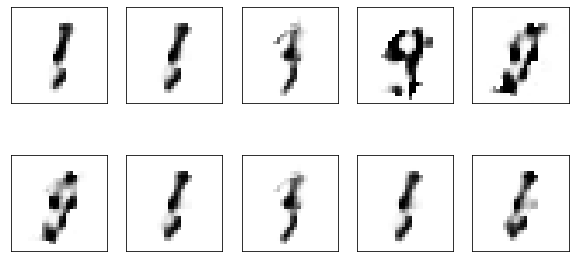

epoch[226] loss_G : 2.8859076, loss_D : 0.124362476
epoch[227] loss_G : 2.9855711, loss_D : 0.14684153
epoch[228] loss_G : 2.8276775, loss_D : 0.11434981
epoch[229] loss_G : 3.1077948, loss_D : 0.11812028
epoch[230] loss_G : 2.9731095, loss_D : 0.1043228


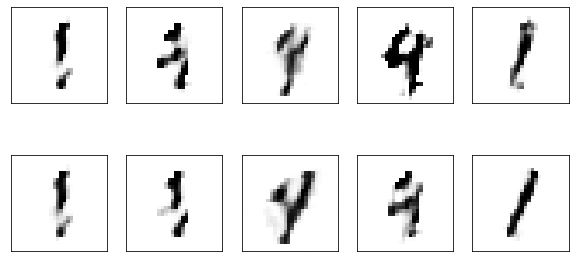

epoch[231] loss_G : 3.1049137, loss_D : 0.11616237
epoch[232] loss_G : 2.583968, loss_D : 0.15986936
epoch[233] loss_G : 2.5210495, loss_D : 0.15036914
epoch[234] loss_G : 2.5223713, loss_D : 0.15976883
epoch[235] loss_G : 2.636496, loss_D : 0.1712407


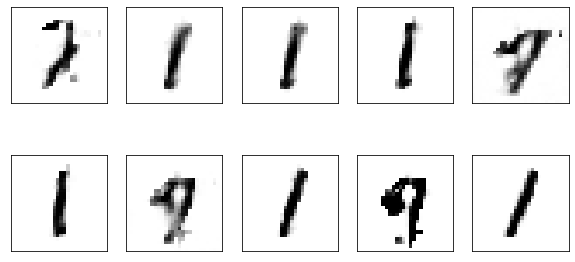

epoch[236] loss_G : 2.5941133, loss_D : 0.16672717
epoch[237] loss_G : 2.2590144, loss_D : 0.17705323
epoch[238] loss_G : 2.611397, loss_D : 0.16744731
epoch[239] loss_G : 2.3052504, loss_D : 0.19792618
epoch[240] loss_G : 2.6066284, loss_D : 0.1388474


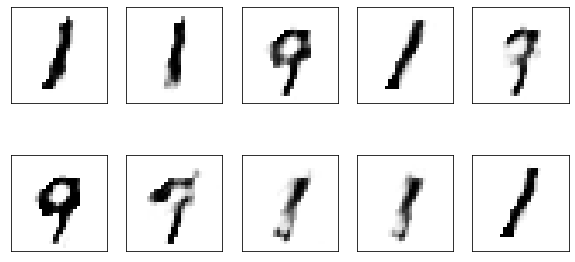

epoch[241] loss_G : 2.7311072, loss_D : 0.1474602
epoch[242] loss_G : 2.754972, loss_D : 0.15174194
epoch[243] loss_G : 2.6224997, loss_D : 0.1461128
epoch[244] loss_G : 2.5910249, loss_D : 0.14765935
epoch[245] loss_G : 2.4040062, loss_D : 0.15870775


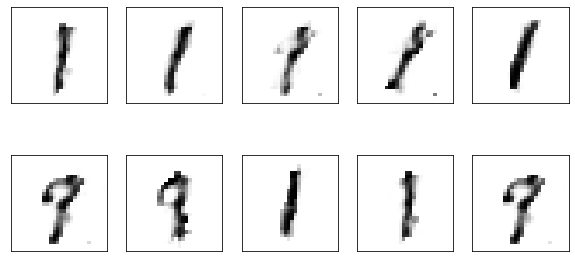

epoch[246] loss_G : 2.630056, loss_D : 0.16066484
epoch[247] loss_G : 2.1902535, loss_D : 0.17577355
epoch[248] loss_G : 2.6127784, loss_D : 0.16018935
epoch[249] loss_G : 2.747271, loss_D : 0.15869206
epoch[250] loss_G : 2.614171, loss_D : 0.1680589


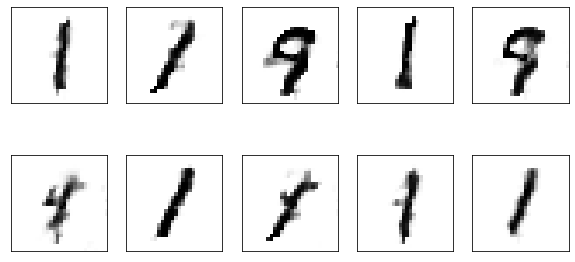

epoch[251] loss_G : 2.4401135, loss_D : 0.18021622
epoch[252] loss_G : 2.4909172, loss_D : 0.16302726
epoch[253] loss_G : 2.5836504, loss_D : 0.1582734
epoch[254] loss_G : 2.7063513, loss_D : 0.14808889
epoch[255] loss_G : 2.7251558, loss_D : 0.16132103


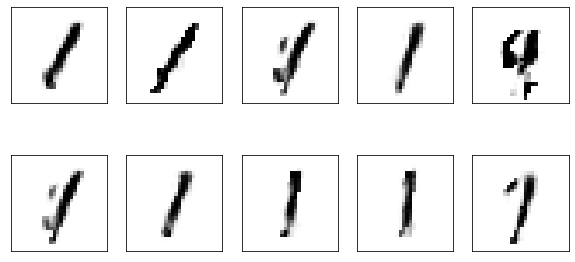

epoch[256] loss_G : 2.4047856, loss_D : 0.18256755
epoch[257] loss_G : 2.6825218, loss_D : 0.18034136
epoch[258] loss_G : 2.4874103, loss_D : 0.18293117
epoch[259] loss_G : 2.5780575, loss_D : 0.164777
epoch[260] loss_G : 2.489974, loss_D : 0.17010146


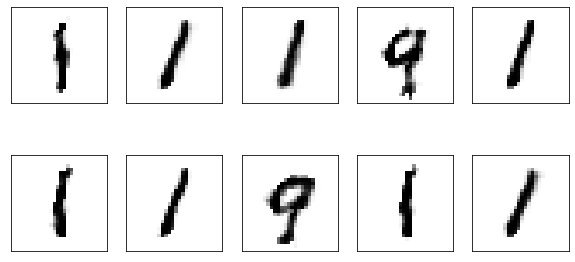

epoch[261] loss_G : 2.2847505, loss_D : 0.20860729
epoch[262] loss_G : 2.2975512, loss_D : 0.19305384
epoch[263] loss_G : 2.288631, loss_D : 0.1868238
epoch[264] loss_G : 2.7886186, loss_D : 0.15432344
epoch[265] loss_G : 2.6798308, loss_D : 0.16545932


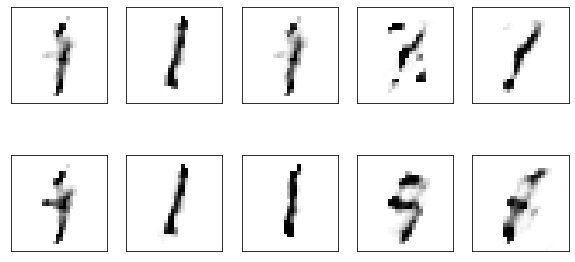

epoch[266] loss_G : 2.562887, loss_D : 0.18058799
epoch[267] loss_G : 2.5476289, loss_D : 0.15282817
epoch[268] loss_G : 2.2402012, loss_D : 0.18392502
epoch[269] loss_G : 2.372054, loss_D : 0.18886232
epoch[270] loss_G : 2.5211666, loss_D : 0.17575099


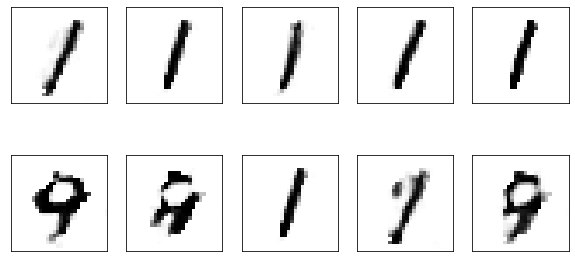

epoch[271] loss_G : 2.487907, loss_D : 0.17798038
epoch[272] loss_G : 2.5578158, loss_D : 0.18038785
epoch[273] loss_G : 2.2779877, loss_D : 0.19138536
epoch[274] loss_G : 2.4551704, loss_D : 0.17110069
epoch[275] loss_G : 2.5217261, loss_D : 0.16347091


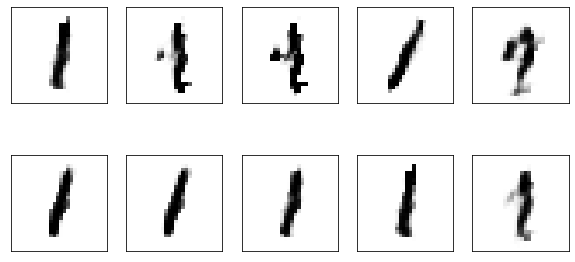

epoch[276] loss_G : 2.5956535, loss_D : 0.17128073
epoch[277] loss_G : 2.711436, loss_D : 0.1561812
epoch[278] loss_G : 2.45811, loss_D : 0.17261977
epoch[279] loss_G : 2.3260965, loss_D : 0.17778082
epoch[280] loss_G : 2.459741, loss_D : 0.19280484


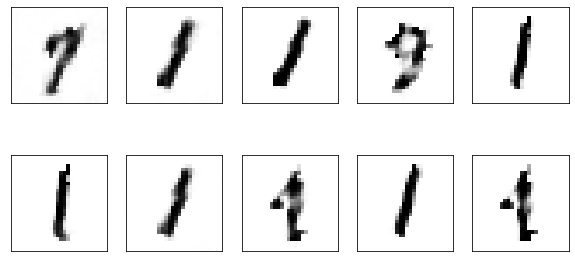

epoch[281] loss_G : 2.403019, loss_D : 0.18360649
epoch[282] loss_G : 2.4181151, loss_D : 0.1922834
epoch[283] loss_G : 2.4463797, loss_D : 0.15510021
epoch[284] loss_G : 2.4489229, loss_D : 0.18189922
epoch[285] loss_G : 2.4946034, loss_D : 0.18082574


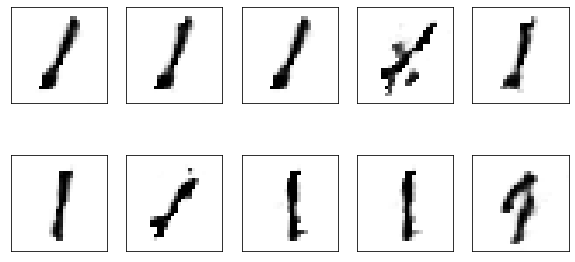

epoch[286] loss_G : 2.3782585, loss_D : 0.18154691
epoch[287] loss_G : 2.2902699, loss_D : 0.1872603
epoch[288] loss_G : 2.4984636, loss_D : 0.16943465
epoch[289] loss_G : 2.2907472, loss_D : 0.18398526
epoch[290] loss_G : 2.5737877, loss_D : 0.15000491


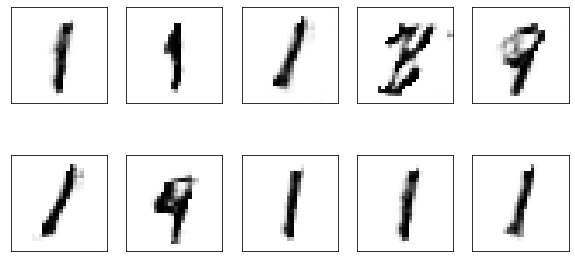

epoch[291] loss_G : 2.51453, loss_D : 0.19153602
epoch[292] loss_G : 2.2859476, loss_D : 0.20504618
epoch[293] loss_G : 2.3119614, loss_D : 0.22467606
epoch[294] loss_G : 2.4244716, loss_D : 0.20640682
epoch[295] loss_G : 2.5155008, loss_D : 0.19671188


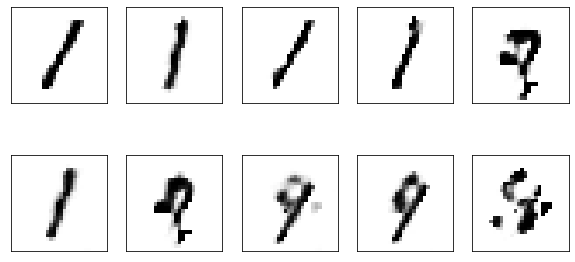

epoch[296] loss_G : 2.4238408, loss_D : 0.20417273
epoch[297] loss_G : 2.3261094, loss_D : 0.17325234
epoch[298] loss_G : 2.6610625, loss_D : 0.17931512
epoch[299] loss_G : 2.7735295, loss_D : 0.16090475
epoch[300] loss_G : 2.3557072, loss_D : 0.18283023


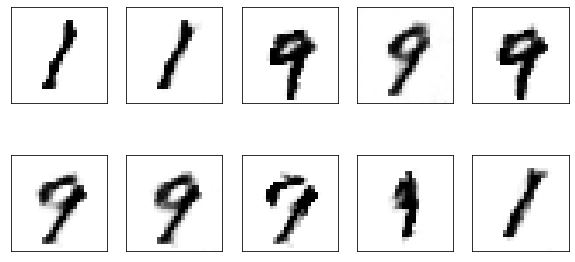

epoch[301] loss_G : 2.3664982, loss_D : 0.1889388
epoch[302] loss_G : 2.4157398, loss_D : 0.18250684
epoch[303] loss_G : 2.2864673, loss_D : 0.19859843
epoch[304] loss_G : 2.3042917, loss_D : 0.19460982
epoch[305] loss_G : 2.749411, loss_D : 0.17404082


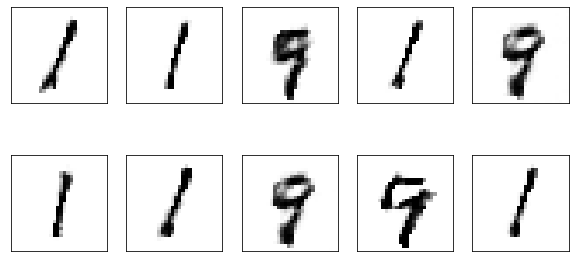

epoch[306] loss_G : 2.5299418, loss_D : 0.1818345
epoch[307] loss_G : 2.568978, loss_D : 0.16689579
epoch[308] loss_G : 2.3107383, loss_D : 0.2123325
epoch[309] loss_G : 2.752457, loss_D : 0.16263294
epoch[310] loss_G : 2.4573371, loss_D : 0.17511922


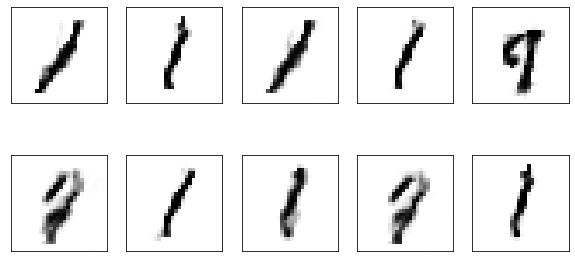

epoch[311] loss_G : 2.6138563, loss_D : 0.17650315
epoch[312] loss_G : 2.3397944, loss_D : 0.1712488
epoch[313] loss_G : 2.2596376, loss_D : 0.19795395
epoch[314] loss_G : 2.3029323, loss_D : 0.18067771
epoch[315] loss_G : 2.2858658, loss_D : 0.21381555


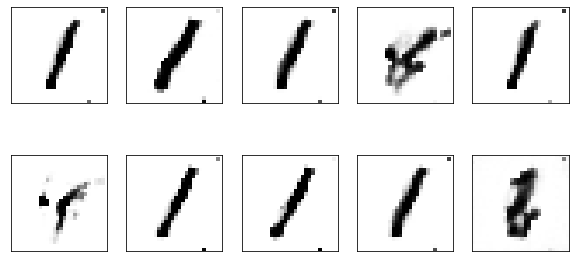

epoch[316] loss_G : 2.5890284, loss_D : 0.1813914
epoch[317] loss_G : 2.4991314, loss_D : 0.18597096
epoch[318] loss_G : 2.7713478, loss_D : 0.14832129
epoch[319] loss_G : 2.5885417, loss_D : 0.16313314
epoch[320] loss_G : 2.4472039, loss_D : 0.19930263


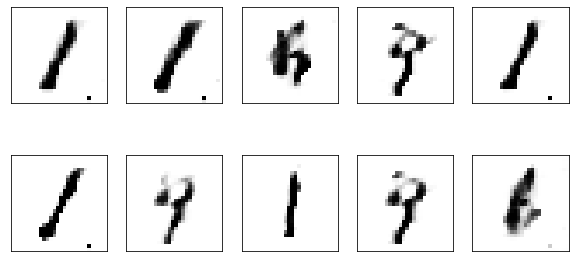

epoch[321] loss_G : 2.5784886, loss_D : 0.18792251
epoch[322] loss_G : 2.4762206, loss_D : 0.18135792
epoch[323] loss_G : 2.653443, loss_D : 0.20299071
epoch[324] loss_G : 2.2797387, loss_D : 0.19414042
epoch[325] loss_G : 2.3575978, loss_D : 0.193501


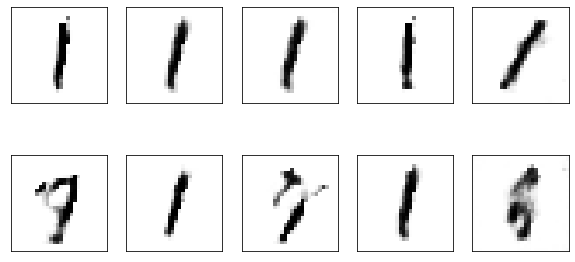

epoch[326] loss_G : 2.2187207, loss_D : 0.20569377
epoch[327] loss_G : 2.5901778, loss_D : 0.1922864
epoch[328] loss_G : 2.3295536, loss_D : 0.189928
epoch[329] loss_G : 2.163433, loss_D : 0.21679349
epoch[330] loss_G : 2.4135573, loss_D : 0.20640671


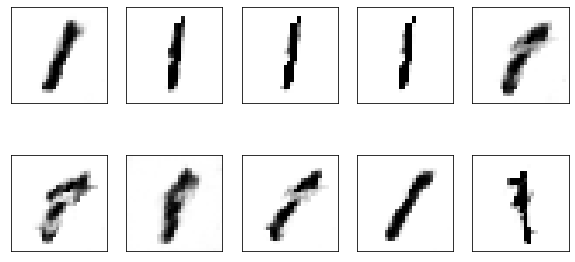

epoch[331] loss_G : 2.4451878, loss_D : 0.18303625
epoch[332] loss_G : 2.413502, loss_D : 0.18023515
epoch[333] loss_G : 2.3617835, loss_D : 0.1736344
epoch[334] loss_G : 2.833267, loss_D : 0.16187039
epoch[335] loss_G : 2.4209533, loss_D : 0.18124142


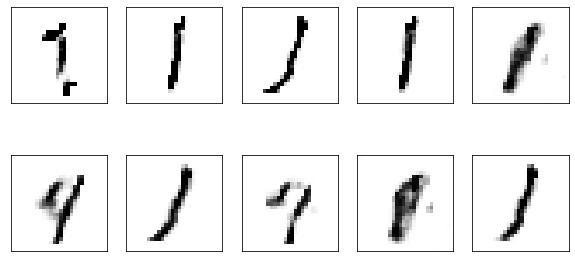

epoch[336] loss_G : 2.52571, loss_D : 0.1679762
epoch[337] loss_G : 2.6751227, loss_D : 0.1793646
epoch[338] loss_G : 2.5461876, loss_D : 0.18988836
epoch[339] loss_G : 2.3664424, loss_D : 0.20214446
epoch[340] loss_G : 2.5190098, loss_D : 0.19390689


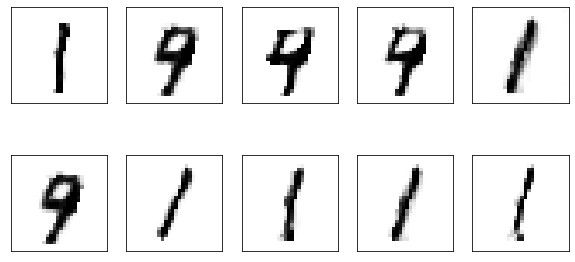

epoch[341] loss_G : 2.6012397, loss_D : 0.18329903
epoch[342] loss_G : 2.2172382, loss_D : 0.20805503
epoch[343] loss_G : 2.3239248, loss_D : 0.20129989
epoch[344] loss_G : 2.4045196, loss_D : 0.21347702
epoch[345] loss_G : 2.5572605, loss_D : 0.19591874


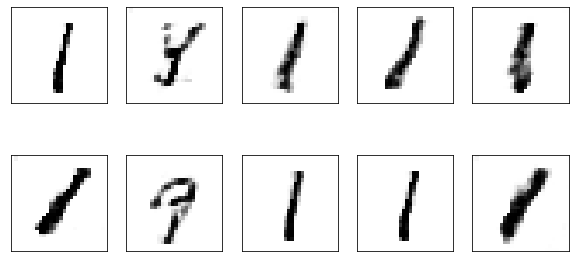

epoch[346] loss_G : 2.2821848, loss_D : 0.18961999
epoch[347] loss_G : 2.4237275, loss_D : 0.19029813
epoch[348] loss_G : 2.8298137, loss_D : 0.17566335
epoch[349] loss_G : 2.5021927, loss_D : 0.20251861
epoch[350] loss_G : 2.245124, loss_D : 0.19662543


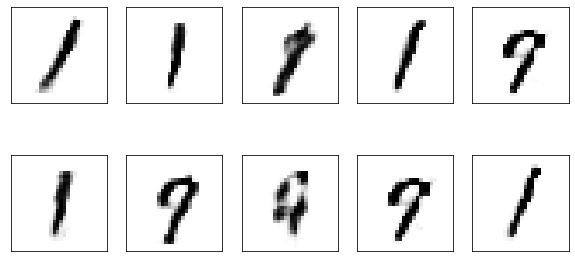

epoch[351] loss_G : 2.303448, loss_D : 0.17949556
epoch[352] loss_G : 2.4468026, loss_D : 0.16877973
epoch[353] loss_G : 2.362354, loss_D : 0.17460175
epoch[354] loss_G : 2.7841938, loss_D : 0.16175619
epoch[355] loss_G : 2.7611296, loss_D : 0.1696958


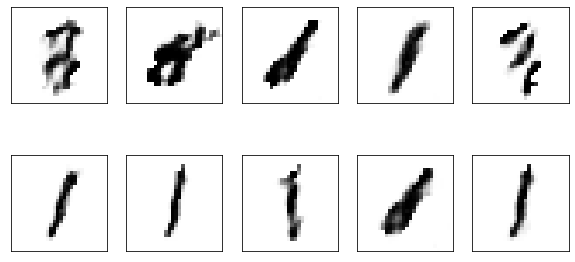

epoch[356] loss_G : 2.5815437, loss_D : 0.15342309
epoch[357] loss_G : 2.6063683, loss_D : 0.16654982
epoch[358] loss_G : 2.6106536, loss_D : 0.17644507
epoch[359] loss_G : 2.7486403, loss_D : 0.14113909
epoch[360] loss_G : 3.032115, loss_D : 0.14946029


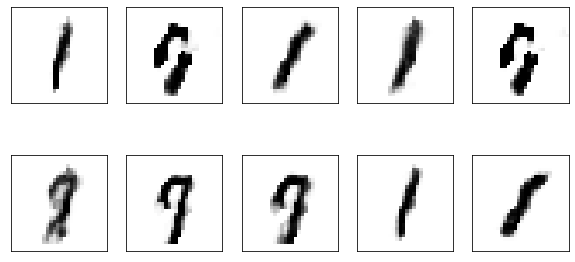

epoch[361] loss_G : 2.4776273, loss_D : 0.17600812
epoch[362] loss_G : 2.5004756, loss_D : 0.18552133
epoch[363] loss_G : 2.459769, loss_D : 0.19006921
epoch[364] loss_G : 2.534498, loss_D : 0.15342377
epoch[365] loss_G : 2.342219, loss_D : 0.2067413


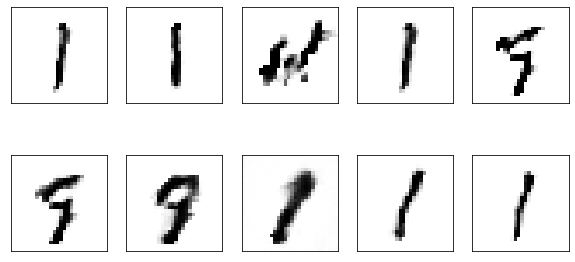

epoch[366] loss_G : 2.4245386, loss_D : 0.20306772
epoch[367] loss_G : 2.6188512, loss_D : 0.17578746
epoch[368] loss_G : 2.4784052, loss_D : 0.1668201
epoch[369] loss_G : 2.377585, loss_D : 0.18007766
epoch[370] loss_G : 2.393887, loss_D : 0.19026303


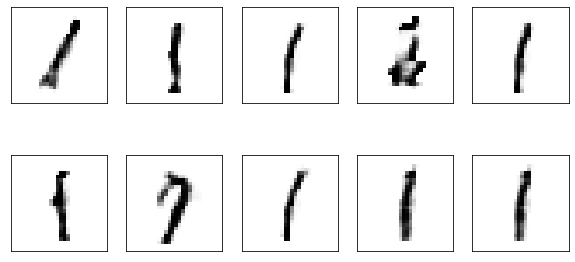

epoch[371] loss_G : 2.3630135, loss_D : 0.19805178
epoch[372] loss_G : 2.3674006, loss_D : 0.1980517
epoch[373] loss_G : 2.3499458, loss_D : 0.20113277
epoch[374] loss_G : 2.5802996, loss_D : 0.20972985
epoch[375] loss_G : 2.3584366, loss_D : 0.18920434


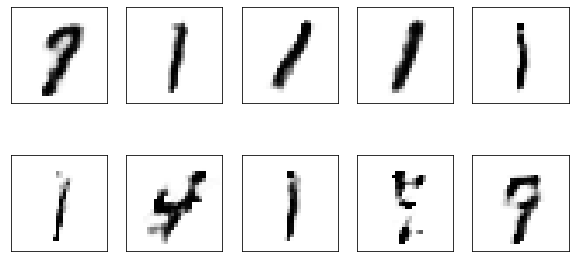

epoch[376] loss_G : 2.392623, loss_D : 0.2062452
epoch[377] loss_G : 2.477314, loss_D : 0.18234733
epoch[378] loss_G : 2.4903085, loss_D : 0.18207517
epoch[379] loss_G : 2.409114, loss_D : 0.19078623
epoch[380] loss_G : 2.4580643, loss_D : 0.18490387


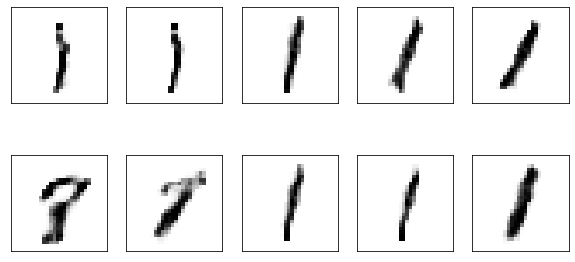

epoch[381] loss_G : 2.5702994, loss_D : 0.16873218
epoch[382] loss_G : 2.6562576, loss_D : 0.18430814
epoch[383] loss_G : 2.5633695, loss_D : 0.15531327
epoch[384] loss_G : 2.565227, loss_D : 0.1410286
epoch[385] loss_G : 2.5726683, loss_D : 0.16425472


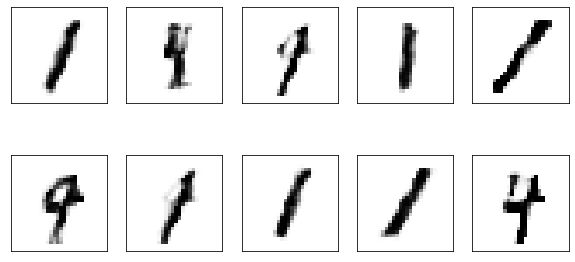

epoch[386] loss_G : 2.4369109, loss_D : 0.1888059
epoch[387] loss_G : 2.420383, loss_D : 0.17502415
epoch[388] loss_G : 2.6168673, loss_D : 0.1601612
epoch[389] loss_G : 2.29794, loss_D : 0.18016513
epoch[390] loss_G : 2.3512332, loss_D : 0.20033182


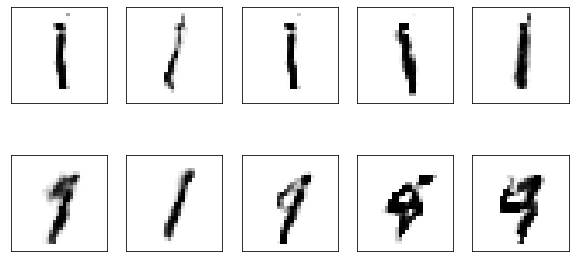

epoch[391] loss_G : 2.2404718, loss_D : 0.18395557
epoch[392] loss_G : 2.1813684, loss_D : 0.18962245
epoch[393] loss_G : 2.4053102, loss_D : 0.1748939
epoch[394] loss_G : 2.6023207, loss_D : 0.16931218
epoch[395] loss_G : 2.3009186, loss_D : 0.1831158


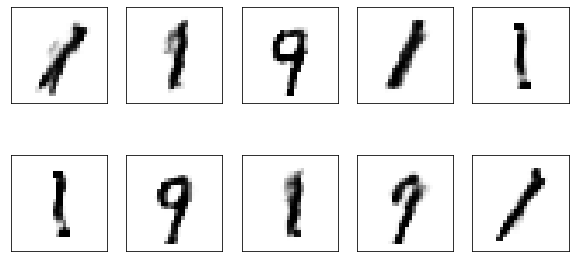

epoch[396] loss_G : 2.1845994, loss_D : 0.21168253
epoch[397] loss_G : 2.481314, loss_D : 0.21460457
epoch[398] loss_G : 2.3755891, loss_D : 0.21074983
epoch[399] loss_G : 2.3876634, loss_D : 0.18990971
epoch[400] loss_G : 2.5427072, loss_D : 0.17394355


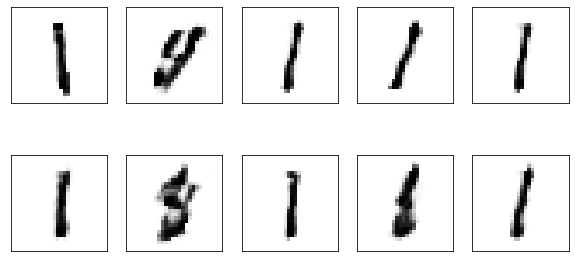

epoch[401] loss_G : 2.3485885, loss_D : 0.18022998
epoch[402] loss_G : 2.827927, loss_D : 0.1479614
epoch[403] loss_G : 2.5484605, loss_D : 0.15464333
epoch[404] loss_G : 2.3799233, loss_D : 0.18496634
epoch[405] loss_G : 2.51864, loss_D : 0.17286071


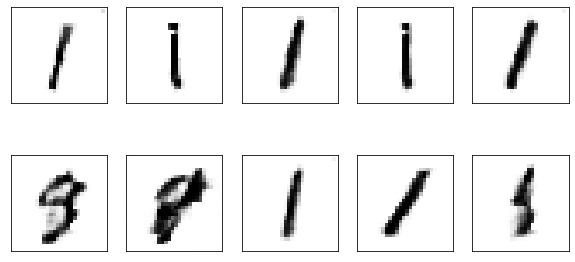

epoch[406] loss_G : 2.3231916, loss_D : 0.18930317
epoch[407] loss_G : 2.5403793, loss_D : 0.19386035
epoch[408] loss_G : 2.537037, loss_D : 0.1872201
epoch[409] loss_G : 2.605165, loss_D : 0.17895968
epoch[410] loss_G : 2.584421, loss_D : 0.18156521


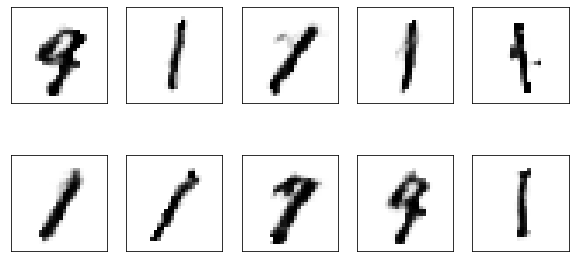

epoch[411] loss_G : 2.544213, loss_D : 0.18333603
epoch[412] loss_G : 2.5551264, loss_D : 0.18518674
epoch[413] loss_G : 2.5532334, loss_D : 0.19453435
epoch[414] loss_G : 2.2933342, loss_D : 0.18352817
epoch[415] loss_G : 2.6354103, loss_D : 0.18538637


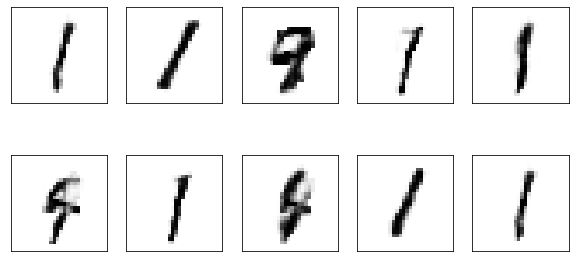

epoch[416] loss_G : 2.4561074, loss_D : 0.20541048
epoch[417] loss_G : 2.1065753, loss_D : 0.21027522
epoch[418] loss_G : 2.512025, loss_D : 0.20506142
epoch[419] loss_G : 2.2584217, loss_D : 0.19023465
epoch[420] loss_G : 2.3084083, loss_D : 0.21632195


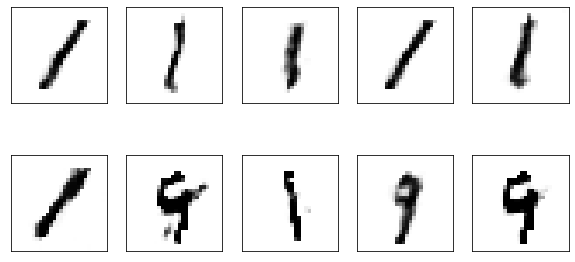

epoch[421] loss_G : 2.4036925, loss_D : 0.19017671
epoch[422] loss_G : 2.0251806, loss_D : 0.22423401
epoch[423] loss_G : 2.0170407, loss_D : 0.23133558
epoch[424] loss_G : 2.522051, loss_D : 0.19783562
epoch[425] loss_G : 2.2770195, loss_D : 0.20140603


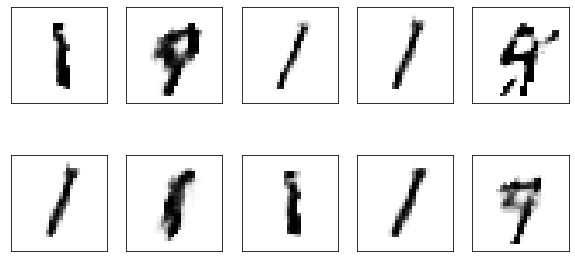

epoch[426] loss_G : 2.166644, loss_D : 0.19781381
epoch[427] loss_G : 2.1353276, loss_D : 0.20266789
epoch[428] loss_G : 2.333622, loss_D : 0.19891466
epoch[429] loss_G : 2.4572315, loss_D : 0.18580256
epoch[430] loss_G : 2.2576857, loss_D : 0.20407473


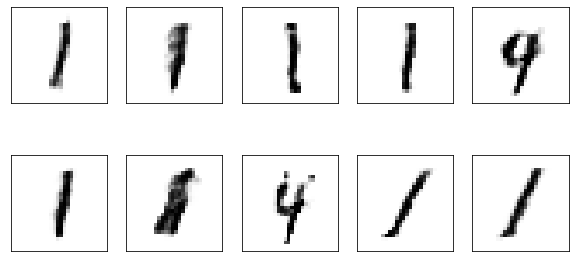

epoch[431] loss_G : 2.282502, loss_D : 0.20572215
epoch[432] loss_G : 2.0225055, loss_D : 0.21160784
epoch[433] loss_G : 2.2022252, loss_D : 0.18796171
epoch[434] loss_G : 2.3587813, loss_D : 0.19024959
epoch[435] loss_G : 2.4086754, loss_D : 0.2020958


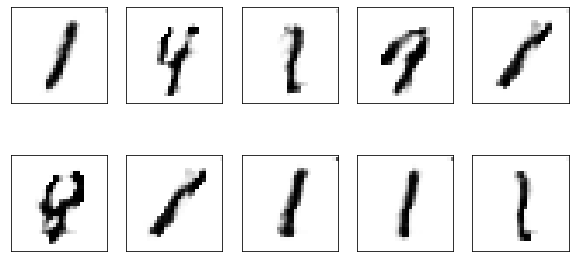

epoch[436] loss_G : 2.3439443, loss_D : 0.19688602
epoch[437] loss_G : 2.3253374, loss_D : 0.19599073
epoch[438] loss_G : 2.4834325, loss_D : 0.18611383
epoch[439] loss_G : 2.5521278, loss_D : 0.183913
epoch[440] loss_G : 2.2576354, loss_D : 0.18686229


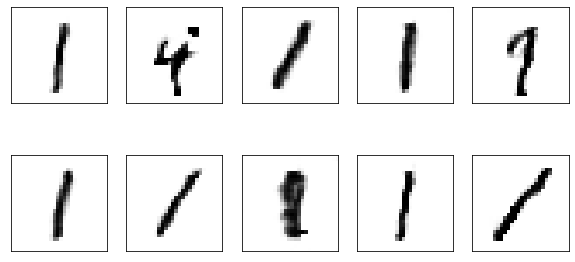

epoch[441] loss_G : 2.3427858, loss_D : 0.18332365
epoch[442] loss_G : 2.3035414, loss_D : 0.20874041
epoch[443] loss_G : 2.331978, loss_D : 0.2064194
epoch[444] loss_G : 2.5786772, loss_D : 0.22764134
epoch[445] loss_G : 2.3214111, loss_D : 0.19922857


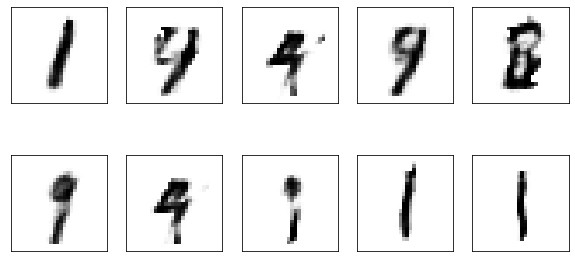

epoch[446] loss_G : 2.359562, loss_D : 0.19868357
epoch[447] loss_G : 2.5568984, loss_D : 0.21003485
epoch[448] loss_G : 2.1989443, loss_D : 0.22451235
epoch[449] loss_G : 2.313451, loss_D : 0.20752573
epoch[450] loss_G : 2.271985, loss_D : 0.21948776


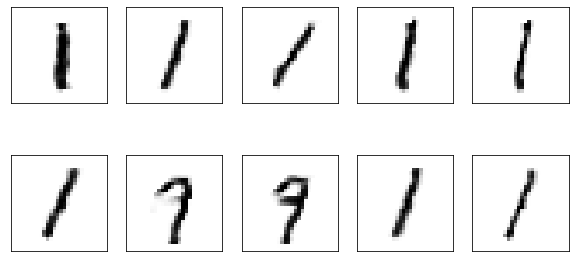

epoch[451] loss_G : 2.190943, loss_D : 0.20682254
epoch[452] loss_G : 2.5817935, loss_D : 0.20643704
epoch[453] loss_G : 2.2335436, loss_D : 0.19577885
epoch[454] loss_G : 2.3285751, loss_D : 0.19019532
epoch[455] loss_G : 2.5843575, loss_D : 0.16859771


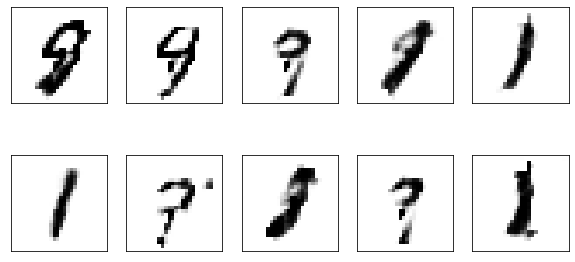

epoch[456] loss_G : 2.4118974, loss_D : 0.19571531
epoch[457] loss_G : 2.5329075, loss_D : 0.1683815
epoch[458] loss_G : 2.4551992, loss_D : 0.19973668
epoch[459] loss_G : 2.2091038, loss_D : 0.22802418
epoch[460] loss_G : 2.276247, loss_D : 0.22983712


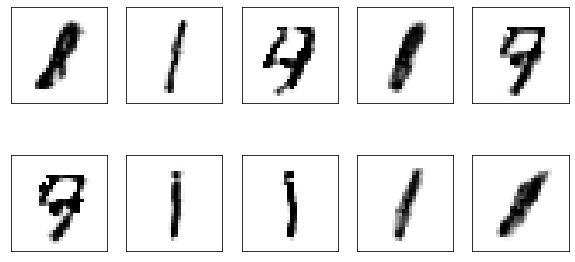

epoch[461] loss_G : 2.0827284, loss_D : 0.211859
epoch[462] loss_G : 2.2934723, loss_D : 0.2167202
epoch[463] loss_G : 2.0921335, loss_D : 0.20252061
epoch[464] loss_G : 2.1099176, loss_D : 0.22051348
epoch[465] loss_G : 2.2956097, loss_D : 0.21379153


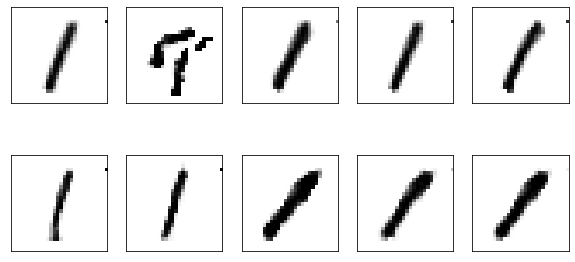

epoch[466] loss_G : 2.47284, loss_D : 0.19097072
epoch[467] loss_G : 2.3391938, loss_D : 0.20089732
epoch[468] loss_G : 2.6866896, loss_D : 0.21709247
epoch[469] loss_G : 2.1053824, loss_D : 0.20688981
epoch[470] loss_G : 2.154918, loss_D : 0.21591936


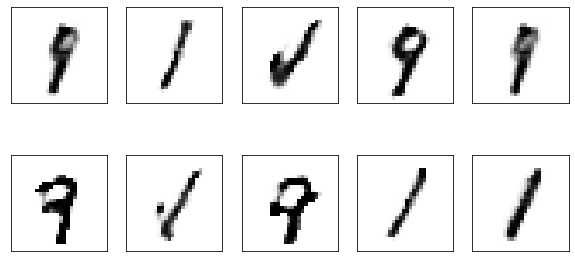

epoch[471] loss_G : 2.25193, loss_D : 0.19962038
epoch[472] loss_G : 2.338564, loss_D : 0.19623601
epoch[473] loss_G : 2.2740037, loss_D : 0.21139771
epoch[474] loss_G : 2.0518105, loss_D : 0.20108384
epoch[475] loss_G : 2.134816, loss_D : 0.20996176


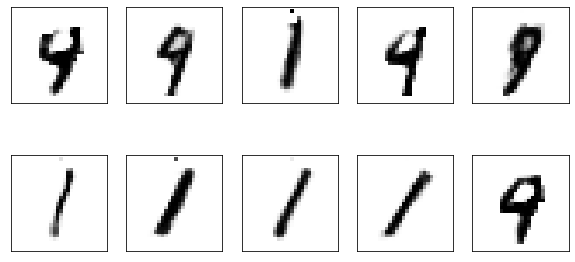

epoch[476] loss_G : 2.2775822, loss_D : 0.20919608
epoch[477] loss_G : 2.2390249, loss_D : 0.21935183
epoch[478] loss_G : 2.2764788, loss_D : 0.20707034
epoch[479] loss_G : 2.517834, loss_D : 0.22396743
epoch[480] loss_G : 2.2551916, loss_D : 0.22385137


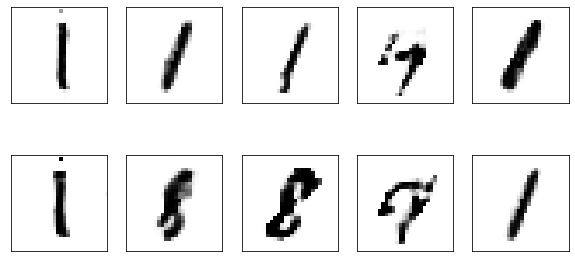

epoch[481] loss_G : 2.3885767, loss_D : 0.21174498
epoch[482] loss_G : 2.2502325, loss_D : 0.22133172
epoch[483] loss_G : 2.2223942, loss_D : 0.2262077
epoch[484] loss_G : 2.3143184, loss_D : 0.21108007
epoch[485] loss_G : 2.191221, loss_D : 0.19310555


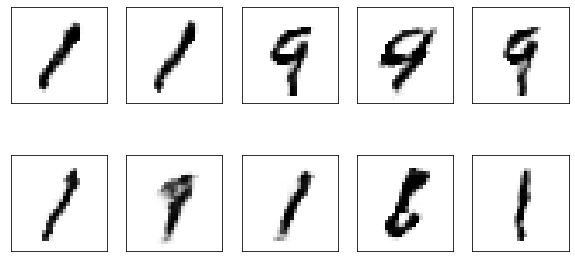

epoch[486] loss_G : 2.1756516, loss_D : 0.20603979
epoch[487] loss_G : 2.194356, loss_D : 0.20767285
epoch[488] loss_G : 2.326803, loss_D : 0.20526299
epoch[489] loss_G : 2.1987019, loss_D : 0.20382558
epoch[490] loss_G : 2.1399372, loss_D : 0.21494009


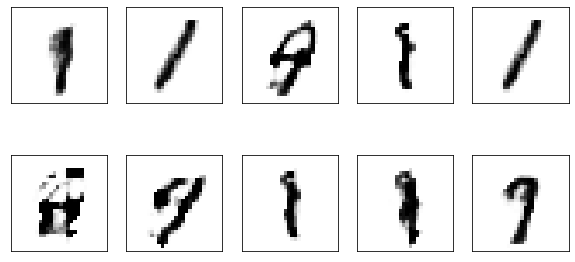

epoch[491] loss_G : 2.0617993, loss_D : 0.2032637
epoch[492] loss_G : 2.2896173, loss_D : 0.2109788
epoch[493] loss_G : 2.1354766, loss_D : 0.20231974
epoch[494] loss_G : 2.1492662, loss_D : 0.21306263
epoch[495] loss_G : 2.129138, loss_D : 0.20320708


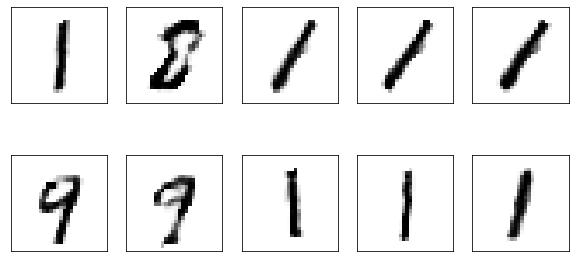

epoch[496] loss_G : 2.1929495, loss_D : 0.21780945
epoch[497] loss_G : 2.153561, loss_D : 0.208878
epoch[498] loss_G : 2.235942, loss_D : 0.2059778
epoch[499] loss_G : 2.244847, loss_D : 0.21115899


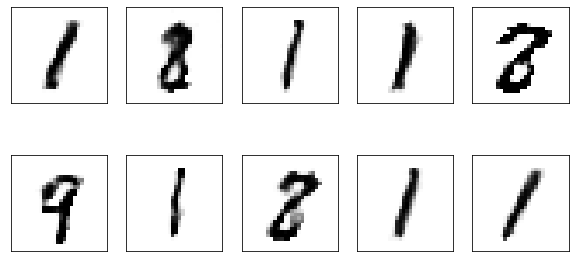

In [33]:
gan = GAN()
gan.train()

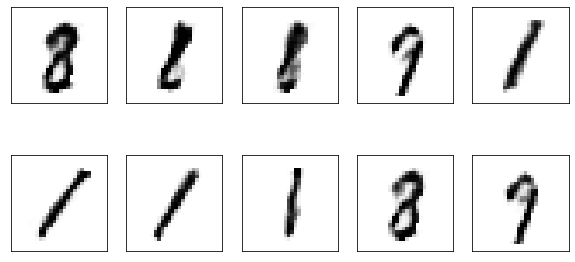

In [69]:
create_num=10
created_image = gan.generator.predict(gan._create_noise(create_num))
created_image = tf.reshape(created_image, (create_num, 28, 28))
created_image = created_image*255
gan._show_image(created_image)

